**Poetry Generator (RNN Markov)**

Here we will generate new poems in the style of Notorious B.I.G. and Lil Wayne.

This scipt uses Recurrent Neural Networks and Markov Chains in order to generate new verses in the style of the poems that it is given as input.  The Markovify functions (Markov Chains) are used to build new sentences (based off of word1=>word2 probabilities), while the Keras.LSTM functions (Recurrent Neural Networks) are used to predict the properties of the next line of the poem (e.g. # syllables, rhyme scheme), such that an appropriate new sentence can be selected (from the setences that were generated with Markovify).

Here are the first 1000 characters from the collection of poems by Notorious B.I.G.

In [1]:
artist_file = '../input/notorious_big.txt'
with open(artist_file) as f: # The with keyword automatically closes the file when you are done
    print (f.read(1000))

﻿baby It was all a dream
I used to read Word Up magazine
Salt n Pepa and Heavy D up in the limousine
Hangin pictures on my wall
Every Saturday Rap Attack Mr Magic Marley Marl
I let my tape rock til my tape popped
Smokin weed and Bambu sippin on Private Stock
Way back when I had the red and black lumberjack
With the hat to match
Remember Rappin Duke duhha duhha
You never thought that hip hop would take it this far
Now Im in the limelight cause I rhyme tight
Time to get paid blow up like the World Trade
Born sinner the opposite of a winner
Remember when I used to eat sardines for dinner
Peace to Ron G Brucey B Kid Capri
Funkmaster Flex Lovebug Starski wassup
Im blowin up like you thought I would
Call the crib same number same hood thats right
Its all good its aaalll good
And if you dont know now you know niXga You know very well who you are
Dont let em hold you down reach for the stars
You had a few but not that many
Cause youre the only one Ill give you good and plenty I made the change

Here are the first 1000 characters from the collection of poems by Lil Wayne

In [2]:
artist_file = '../input/Lil_Wayne.txt'
with open(artist_file) as f: # The with keyword automatically closes the file when you are done
    print (f.read(1000))

﻿They call me Mr Carter I kissed the daughter
Of the deads forehead I killed the father
Spilled the heart of a mildew hater
I will put them body on chill like glaciers
Gracias Im crazy yes its obvious
Going against me is atheist
I got my angels on my shoulders and a quarter of that angel dust
I aint sniffin Im just pitchin ya honor I aint snitchin ya honor
Hate bitch niXgas bitches with power
Vacate when the kitchen get hotter
I just sit on the counter open the cabinet close the cupboard
Put that jar in the skillet drop a four in the bubbles
I remember being young tryin to hustle my dough
Tryin to tell the old junkies that my crack aint soap
Tryin to tell you fool you chump that my mack aint broke
You aint tryin to see how far that black back lane go
No call me Pacman you ghosts is blue
I got my red river rubies and my oceans blue
Jewelry usually Im a hooligan for the money
Yeah Im eatin but I got a tapeworm in my tummy oh
Make harm in the bomb you in public
Hit you with the straight a

Plot word frequencies for .txt files

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
def plotWordFrequency(input):
    f = open(artist_file,'r')
    words = [x for y in [l.split() for l in f.readlines()] for x in y]
    data = sorted([(w, words.count(w)) for w in set(words)], key = lambda x:x[1], reverse=True)[:40] 
    most_words = [x[0] for x in data]
    times_used = [int(x[1]) for x in data]
    plt.figure(figsize=(20,10))
    plt.bar(x=sorted(most_words), height=times_used, color = 'grey', edgecolor = 'black',  width=.5)
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(rotation=0, fontsize=18)
    plt.xlabel('Most Common Words:', fontsize=18)
    plt.ylabel('Number of Occurences:', fontsize=18)
    plt.title('Most Commonly Used Words: %s' % (artist_file), fontsize=24)
    plt.show()

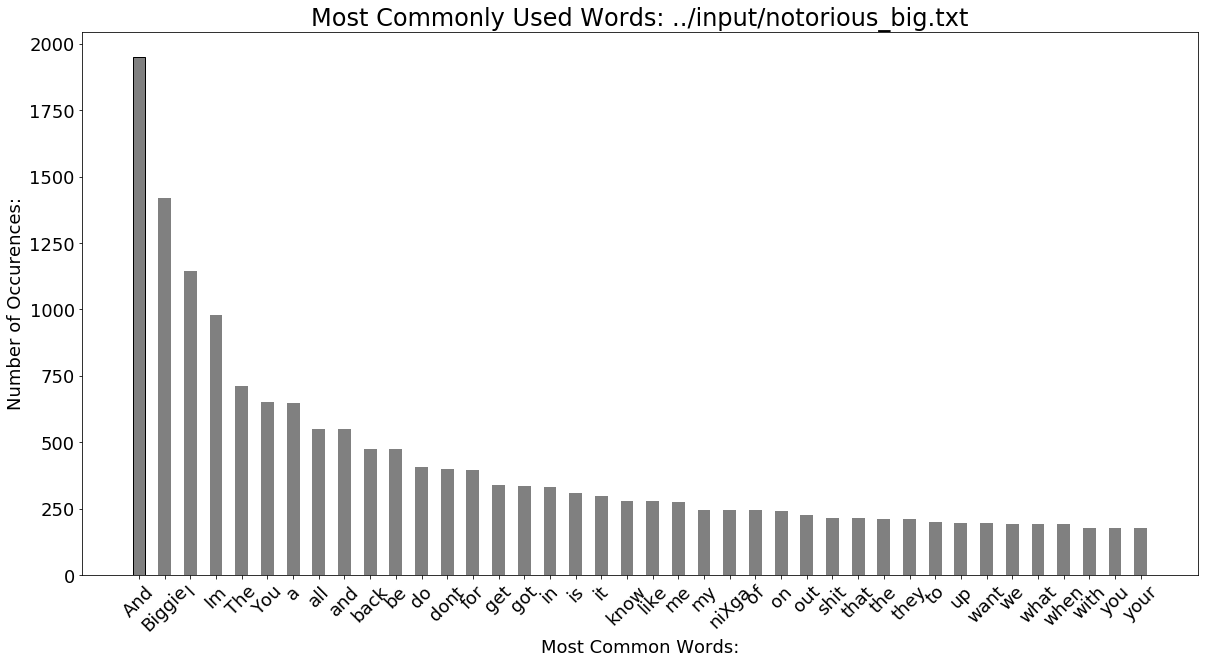

In [4]:
artist_file = '../input/notorious_big.txt'
plotWordFrequency(artist_file)

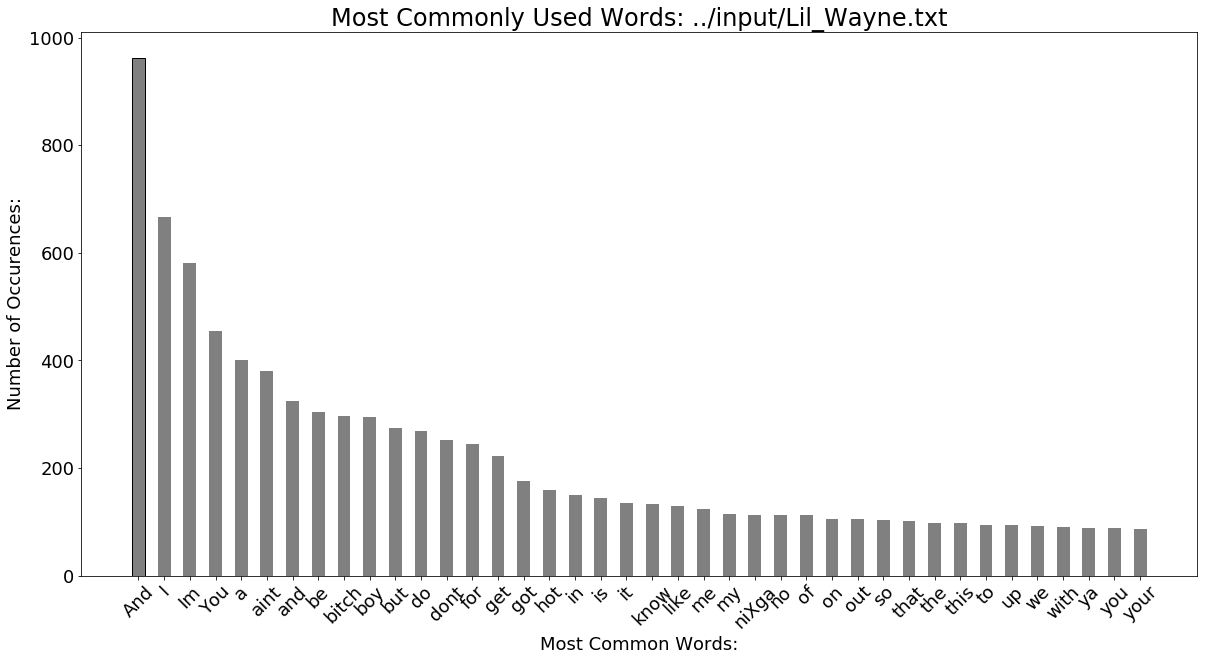

In [5]:
artist_file = '../input/Lil_Wayne.txt'
plotWordFrequency(artist_file)

Here we use Recurrent Neural Networks and Markov chains to generate new lyrics in the style of the input text.
The Markovify functions (Markov Chains) are used to build new sentences (based off of word1=>word2 probabilities), while the Keras.LSTM functions (Recurrent Neural Networks) are used to predict the properties of the next line of the poem (e.g. # syllables, rhyme scheme), such that an appropriate new sentence can be selected (from the setences that were generated with Markovify).

In [6]:
import pronouncing
import markovify
import re
import random
import numpy as np
import os
import keras
from keras.models import Sequential
from keras.layers import LSTM 
from keras.layers.core import Dense

Using TensorFlow backend.


Recurrent Neural Network (https://keras.io/layers/recurrent/#lstm)

In [7]:
def create_network(depth):
	model = Sequential()
	model.add(LSTM(4, input_shape=(2, 2), return_sequences=True))
	for i in range(depth):
		model.add(LSTM(8, return_sequences=True))
	model.add(LSTM(2, return_sequences=True))
	model.summary()
	model.compile(optimizer='rmsprop',
              loss='mse')
	if artist + ".rap" in os.listdir(".") and train_mode == False:
		model.load_weights(str(artist + ".rap"))
		print("loading saved network: " + str(artist) + ".rap") 
	return model

Markov Chain (https://github.com/jsvine/markovify)

In [8]:
def markov(text_file):
    ######
	read = open(text_file, "r", encoding='utf-8').read()
	text_model = markovify.NewlineText(read)
	return text_model

Determine number of syllables in line

In [9]:
def syllables(line):
	count = 0
	for word in line.split(" "):
		vowels = 'aeiouy'
# 		word = word.lower().strip("!@#$%^&*()_+-={}[];:,.<>/?")
		word = word.lower().strip(".:;?!")
		if word[0] in vowels:
			count +=1
		for index in range(1,len(word)):
			if word[index] in vowels and word[index-1] not in vowels:
				count +=1
		if word.endswith('e'):
			count -= 1
		if word.endswith('le'):
			count+=1
		if count == 0:
			count +=1
	return count / maxsyllables

Make index of words that rhyme with your word

In [10]:
def rhymeindex(lyrics):
	if str(artist) + ".rhymes" in os.listdir(".") and train_mode == False:
		print ("loading saved rhymes from " + str(artist) + ".rhymes")
		return open(str(artist) + ".rhymes", "r",encoding='utf-8').read().split("\n")
	else:
		rhyme_master_list = []
		print ("Building list of rhymes:")
		for i in lyrics:
			word = re.sub(r"\W+", '', i.split(" ")[-1]).lower()
			rhymeslist = pronouncing.rhymes(word)
			rhymeslistends = []      
			for i in rhymeslist:
				rhymeslistends.append(i[-2:])
			try:
				rhymescheme = max(set(rhymeslistends), key=rhymeslistends.count)
			except Exception:
				rhymescheme = word[-2:]
			rhyme_master_list.append(rhymescheme)
		rhyme_master_list = list(set(rhyme_master_list))
		reverselist = [x[::-1] for x in rhyme_master_list]
		reverselist = sorted(reverselist)
		rhymelist = [x[::-1] for x in reverselist]
		print("List of Sorted 2-Letter Rhyme Ends:")
		print(rhymelist)
		f = open(str(artist) + ".rhymes", "w", encoding='utf-8')
		f.write("\n".join(rhymelist))
		f.close()
		return rhymelist

Make index of rhymes that you use

In [11]:
def rhyme(line, rhyme_list):
	word = re.sub(r"\W+", '', line.split(" ")[-1]).lower()
	rhymeslist = pronouncing.rhymes(word)
	rhymeslistends = []
	for i in rhymeslist:
		rhymeslistends.append(i[-2:])
	try:
		rhymescheme = max(set(rhymeslistends), key=rhymeslistends.count)
	except Exception:
		rhymescheme = word[-2:]
	try:
		float_rhyme = rhyme_list.index(rhymescheme)
		float_rhyme = float_rhyme / float(len(rhyme_list))
		return float_rhyme
	except Exception:
		float_rhyme = None
		return float_rhyme

Separate each line of the input txt

In [12]:
def split_lyrics_file(text_file):
	text = open(text_file, encoding='utf-8').read()
	text = text.split("\n")
	while "" in text:
		text.remove("")
	return text

Generate lyrics

In [13]:
def generate_lyrics(text_model, text_file):
	bars = []
	last_words = []
	lyriclength = len(open(text_file,encoding='utf-8').read().split("\n"))
	count = 0
	markov_model = markov(text_file)
	
	while len(bars) < lyriclength / 9 and count < lyriclength * 2:
		bar = markov_model.make_sentence(max_overlap_ratio = .49, tries=100)
		if type(bar) != type(None) and syllables(bar) < 1:
			def get_last_word(bar):
				last_word = bar.split(" ")[-1]
				if last_word[-1] in "!.?,":
					last_word = last_word[:-1]
				return last_word
			last_word = get_last_word(bar)
			if bar not in bars and last_words.count(last_word) < 3:
				bars.append(bar)
				last_words.append(last_word)
				count += 1
	return bars

Build dataset

In [14]:
def build_dataset(lines, rhyme_list):
	dataset = []
	line_list = []
	for line in lines:
		line_list = [line, syllables(line), rhyme(line, rhyme_list)]
		dataset.append(line_list)
	x_data = []
	y_data = []
	for i in range(len(dataset) - 3):
		line1 = dataset[i    ][1:]
		line2 = dataset[i + 1][1:]
		line3 = dataset[i + 2][1:]
		line4 = dataset[i + 3][1:]
		x = [line1[0], line1[1], line2[0], line2[1]]
		x = np.array(x)
		x = x.reshape(2,2)
		x_data.append(x)
		y = [line3[0], line3[1], line4[0], line4[1]]
		y = np.array(y)
		y = y.reshape(2,2)
		y_data.append(y)
	x_data = np.array(x_data)
	y_data = np.array(y_data)
	return x_data, y_data

Compose verse

In [15]:
def compose_rap(lines, rhyme_list, lyrics_file, model):
	rap_vectors = []
	human_lyrics = split_lyrics_file(lyrics_file)
	initial_index = random.choice(range(len(human_lyrics) - 1))
	initial_lines = human_lyrics[initial_index:initial_index + 2]
	starting_input = []
	for line in initial_lines:
		starting_input.append([syllables(line), rhyme(line, rhyme_list)])
	starting_vectors = model.predict(np.array([starting_input]).flatten().reshape(1, 2, 2))
	rap_vectors.append(starting_vectors)
	for i in range(100):
		rap_vectors.append(model.predict(np.array([rap_vectors[-1]]).flatten().reshape(1, 2, 2)))
	return rap_vectors

Compose verse (part 2)

In [16]:
def vectors_into_song(vectors, generated_lyrics, rhyme_list):
	print ("\n\n")	
	print ("Writing verse:")
	print ("\n\n")
	def last_word_compare(rap, line2):
		penalty = 0 
		for line1 in rap:
			word1 = line1.split(" ")[-1]
			word2 = line2.split(" ")[-1]
			while word1[-1] in "?!,. ":
				word1 = word1[:-1]
			while word2[-1] in "?!,. ":
				word2 = word2[:-1]
			if word1 == word2:
				penalty += 0.2
		return penalty
	def calculate_score(vector_half, syllables, rhyme, penalty):
		desired_syllables = vector_half[0]
		desired_rhyme = vector_half[1]
		desired_syllables = desired_syllables * maxsyllables
		desired_rhyme = desired_rhyme * len(rhyme_list)
		score = 1.0 - abs(float(desired_syllables) - float(syllables)) + abs(float(desired_rhyme) - float(rhyme)) - penalty
		return score
	dataset = []
	for line in generated_lyrics:
		line_list = [line, syllables(line), rhyme(line, rhyme_list)]
		dataset.append(line_list)
	rap = []
	vector_halves = []
	for vector in vectors:
		vector_halves.append(list(vector[0][0])) 
		vector_halves.append(list(vector[0][1]))
	for vector in vector_halves:
		scorelist = []
		for item in dataset:
			line = item[0]
			if len(rap) != 0:
				penalty = last_word_compare(rap, line)
			else:
				penalty = 0
			total_score = calculate_score(vector, item[1], item[2], penalty)
			score_entry = [line, total_score]
			scorelist.append(score_entry)
		fixed_score_list = [0]
		for score in scorelist:
			fixed_score_list.append(float(score[1]))
		max_score = max(fixed_score_list)
		for item in scorelist:
			if item[1] == max_score:
				rap.append(item[0])
				print (str(item[0]))
				for i in dataset:
					if item[0] == i[0]:
						dataset.remove(i)
						break
				break     
	return rap

Traning function

In [17]:
def train(x_data, y_data, model):
	model.fit(np.array(x_data), np.array(y_data),
			  batch_size=2,
			  epochs=5,
			  verbose=1)
	model.save_weights(artist + ".rap")

Train and run the model

In [18]:
def main(depth, train_mode):
	model = create_network(depth)
	text_model = markov(text_file)
	if train_mode == True:
		bars = split_lyrics_file(text_file)
	if train_mode == False:
		bars = generate_lyrics(text_model, text_file)
	rhyme_list = rhymeindex(bars)
	if train_mode == True:
		x_data, y_data = build_dataset(bars, rhyme_list)
		train(x_data, y_data, model)
	if train_mode == False:
		vectors = compose_rap(bars, rhyme_list, text_file, model)
		rap = vectors_into_song(vectors, bars, rhyme_list)
		f = open(rap_file, "w", encoding='utf-8')
		for bar in rap:
			f.write(bar)
			f.write("\n")

Some important parameters to keep in mind are as follows: (1) maxsyllables: max # of syllables per line; (2) max_overlap_ratio: how different the output should be from the original input; (3) tries: how many times to try to build a line that satisifies some parameter; (4) epochs: how many times for the NN to pass over the data.

To reduce computational complexity, maximize (1) and (2) and minimize (3) and (4).  
Computational time will increase dramatically when (1) is less than 8 and when (2) is less than 0.5

In [19]:
depth = 4 
maxsyllables = 8
artist = "artist"
rap_file = "temporary_poem.txt"

Write new lyrics in the style of Notorious B.I.G..

In [20]:
maxsyllables = 8
text_file = "../input/notorious_big.txt"
train_mode = True        
main(depth, train_mode)
train_mode = False
main(depth, train_mode)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2, 4)              112       
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 8)              416       
_________________________________________________________________
lstm_3 (LSTM)                (None, 2, 8)              544       
_________________________________________________________________
lstm_4 (LSTM)                (None, 2, 8)              544       
_________________________________________________________________
lstm_5 (LSTM)                (None, 2, 8)              544       
_________________________________________________________________
lstm_6 (LSTM)                (None, 2, 2)              88        
Total params: 2,248
Trainable params: 2,248
Non-trainable params: 0
_________________________________________________________________
Building

By now you know Im the high guy
All I do what I mean
Dress up like you just shine
Fuck em in a long prayer
I spit on the corner store
You cant touch me you would die for
Fk up the way to Maryland
I thought he was in the world go round
hope you got a hundred grand
I want to fuck with the Goldie sound
When Im done I got the phone and
Cause one of my mind state
NiXgas start to get the boot
Make up to your ass yet
Take off that shit I wrote
Fuck that shit like a glove
Uhh to all the guns and shoot dice
And I can be the topic
Then they come for you to die well see
I dont fuck with me in my back
See who got the best in New Jack
And when the cops tried to get stuck
What you what you need to be black
And cmon if you can hit the DECK
Things to make your fuckin neck
Except when I see that shit the fuck
No spouse in the summer for the funk
We dont play me at 546
What you wanna go to jail
Step out show me the money in pool
You sayin I got to be a crook
Cause I got the gat to the spring
Just Bone a

Write new lyrics in the style of Lil Wayne

In [21]:
text_file = "../input/Lil_Wayne.txt"
maxsyllables = 8
train_mode = True        
main(depth, train_mode)
train_mode = False
main(depth, train_mode)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 2, 4)              112       
_________________________________________________________________
lstm_14 (LSTM)               (None, 2, 8)              416       
_________________________________________________________________
lstm_15 (LSTM)               (None, 2, 8)              544       
_________________________________________________________________
lstm_16 (LSTM)               (None, 2, 8)              544       
_________________________________________________________________
lstm_17 (LSTM)               (None, 2, 8)              544       
_________________________________________________________________
lstm_18 (LSTM)               (None, 2, 2)              88        
Total params: 2,248
Trainable params: 2,248
Non-trainable params: 0
_________________________________________________________________
Building

No Cash Money is the ocean
So on the scene on a Full moon
In this bitch and a ribbon
And peek how you like a shoe horn
Me I got a full deck
I dont want to go back
She know Im on them hoes
They say the best to do this son
Now she want to wake up with the K why
But I gotta get em high
Ooh boo you can see by the light
Im here to see her on sight
And Slim tell me bring it on down
Underground shit I want the change
Aww shit I see em I
And dawg I live to be Lil Wayne
Trying to get to the VIP
Gotta know that Im on the whip
That I love that I would talk
Suck the dick in the heat get out limp
Just fuck with me what to come
Cause I live to be Lil Wayne nop
Hate bitch niXgas like a cop
Thats life to me right in the head
Bitch I put it back ma
The back of the line crooked
On the day I went to the script yup
Is how I see her again
Fuck you bitch got a bitch
Tell me what to come home
Boy we do it for nothin
Fuck you and we made it this far
I see it in a reservoir
Me and my goons to kill me here
Now 

Write new lyrics in the combined style of Notorious B.I.G. and Lil Wayne.

In [22]:
filenames = ['../input/Lil_Wayne.txt', '../input/notorious_big.txt']
with open('combined.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

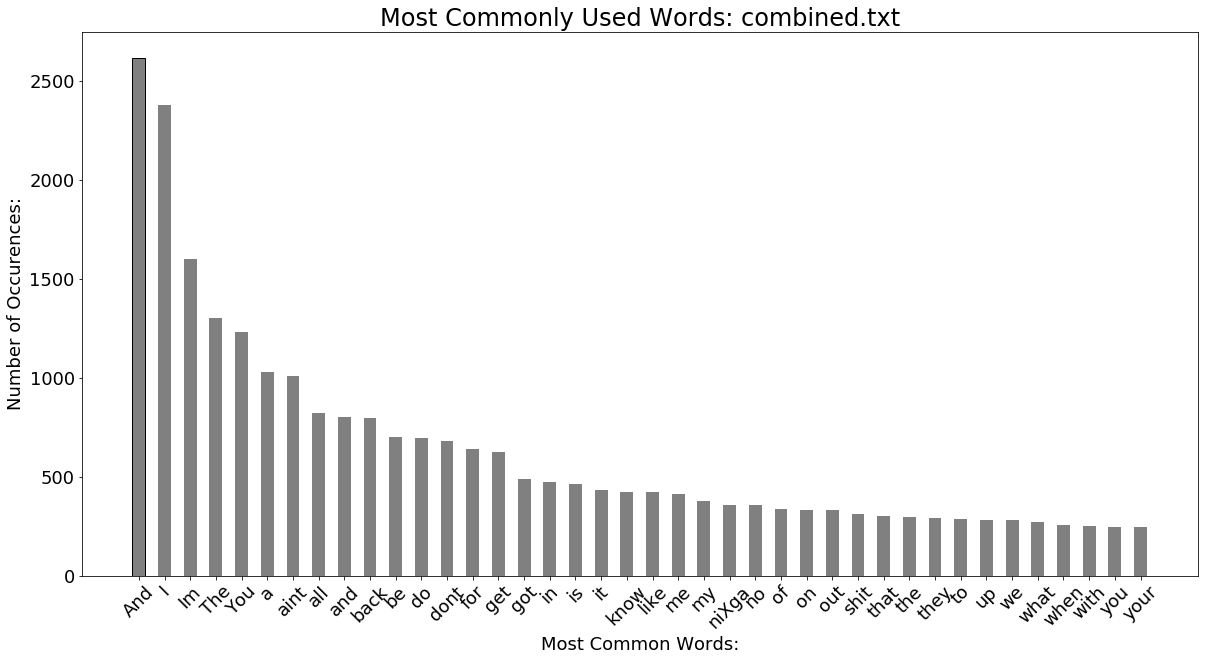

In [23]:
#artist_file = '../input/combined.txt'
artist_file = 'combined.txt'
plotWordFrequency(artist_file)

In [24]:
maxsyllables = 8
text_file = "combined.txt"
train_mode = True        
main(depth, train_mode)
train_mode = False
main(depth, train_mode)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 2, 4)              112       
_________________________________________________________________
lstm_26 (LSTM)               (None, 2, 8)              416       
_________________________________________________________________
lstm_27 (LSTM)               (None, 2, 8)              544       
_________________________________________________________________
lstm_28 (LSTM)               (None, 2, 8)              544       
_________________________________________________________________
lstm_29 (LSTM)               (None, 2, 8)              544       
_________________________________________________________________
lstm_30 (LSTM)               (None, 2, 2)              88        
Total params: 2,248
Trainable params: 2,248
Non-trainable params: 0
_________________________________________________________________
Building

Your so You know we aint no love
I live for the bread and the heatll move
Who was there when she hit the club
I fuck around with a spliff
NiXgaz tryin to take it off
How we would be with me believe me its tough
Step off in the streets is my half
See what I want it niXga
I see you with the shit real bad
NiXga like me I get witcha
My bitch got a body bag
Blinded by the hood like a drag
She ask me for my man next
Said he had a whole fiend
Shit you just dont be strapped
What you want to be trialed
Had to tell the cops crashed
Im a man in his hand
It aint nothing but the ground
Just fuck with her man she said BIG
What we gon get you in your wig
A true G thats me thats Weezy F Im big
But fuck that Im so hood
Back shots is my shit Stop the song
Uh and if the hooker thinking
Slam ya like I was choking
I stream through the beach and we was doing
And I aint seen the light Skull Gang
Come on the way it is so wrong
Cause I dont have to you thong
Huh Im doin all the shots whistling
Kept my shit Sto

Credit: Some of the functions were adapted from the following script:  https://github.com/robbiebarrat/rapping-neural-network/blob/master/model.py.  For more information, see the following links:  http://www.emnlp2015.org/proceedings/EMNLP/pdf/EMNLP221.pdf and https://arxiv.org/pdf/1612.03205.pdf.

To Do: (1) Add More Pre-Processing Steps; (2) Increase Size of Individual Lyric Files; (3) Numbers should not rhyme with other numbers